# PyTorch Workflow
- by Daniel Bourke

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.0'

## 1. Data (preparing and loading)

1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representations.

Linear Regression with known **parameters**

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
squeezed_X = torch.arange(start, end, step)
unsqueezed_X = squeezed_X.unsqueeze(dim=1) # add extra dim
y = weight * unsqueezed_X + bias

In [4]:
# y

In [5]:
len(unsqueezed_X), len(y)

(50, 50)

### Splitting data

- **GOAL:** Generalization [to perform well on data it hasn't seen before]
    - Training set (ie: course materials)
    - Validation set (ie: practice exam)
    - Testing set (ie: final exam)

- There's a direct mapping of training set : testing set

In [6]:
train_split_len = int(0.8 * len(unsqueezed_X))
train_split_len

40

In [7]:
X_train, y_train = unsqueezed_X[:train_split_len], y[:train_split_len]
len(X_train), len(y_train)

(40, 40)

In [8]:
X_test, y_test = unsqueezed_X[train_split_len:], y[train_split_len:]
len(X_test), len(y_test)

(10, 10)

How might we better visualize out data?

In [9]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """Plots training data, test data, and compares predictions"""

    plt.figure(figsize=(5, 5))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size": 14})

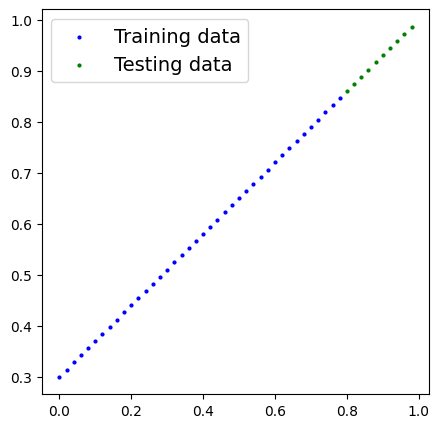

In [10]:
plot_predictions()

## 2. Build model

- Using OOP in Python. See Real Python: https://realpython.com/python3-object-oriented-programming/
- `Linear Regression Model`
    1. Goal is to draw the line that passes as close as possible to the points [1 | P 36]
    2. Mathematical representation [2 | P 19]
        $$
        y(x) = w^T \cdot x + \epsilon = \sum_{j=1}^D w_j \cdot x_j + \epsilon
        $$
        
        - $w$, weights
        - $\cdot$, matrix multiplication [3]
        - $x$, input vector
        - $\epsilon$, residual error or learnable bias parameter between our linear predictions and the true response
- Process:
    1. Start with random values for our parameters $w$ and $\epsilon$
    2. Look at training data and adjust random our parameters $w$ and $\epsilon$ to be what would represent the line, hence goal of the LR Model to draw the best fitting line.
        - How? Track the gradients [slope] with keyword `require_grad = True` coming from the `torch.autograd` which provides classes and functions.
            1. Gradient descent
                - [adjusts params to find best combination of params]
                - [adjusts the params wrt the loss]
                - Want our model to converge [approach 0 as we calculate GD]
                - Mathematical representation [2 | P 247]
                    $$ \theta_{k + 1} = \theta_k - \eta_kg_k$$
                - See [4] for a visualization or google gradient in ML
            2. Backpropagation [5]

In [ ]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Randomly initializations our learnable model parameters
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

        # Forward method to define the computation in the model
    def forward(self, input_x: torch.Tensor) -> torch.Tensor:
        y = self.weights * input_x + self.bias
        return y

### Checking the contents of our PyTorch model

- Use `.parameters()`

In [ ]:
# Create random seed because we initialize randomly and want to stablize our random values
# stablize as in keep random #s same; remove manual_seed() and model params will change
# helps with reproducing works
torch.manual_seed(42)

# Create instance of model (this is a subclass of of nn.Module)
linear_regression_model = LinearRegressionModel()

# Check out parameters
linear_regression_model.state_dict()

- Want `self.weights` and `self.bias` to be close to the ideal `weights` and `bias` set above

In [ ]:
weight, bias

### Making predictions usings `torch.inference_mode()`

- See how well model predicts `y_test` based on `X_test`
- Pass data through model via `forward()` method
- `torch.inference_mode()` 
    - Removes gradient tracking
    - When doing inference, we're NOT training, so don't need to keep track of gradients/ how to update model
    - Benefit is that it makes code run faster as we're NOT saving gradients

In [ ]:
X_test, y_test

In [ ]:
# Make predictions with model
with torch.inference_mode():
    lr_y_preds = linear_regression_model.forward(X_test)

# Similar as above, however inference_mode is preferred
# with torch.no_grad():
#     lr_y_preds = linear_regression_model.forward(X_test)

lr_y_preds

In [ ]:
plot_predictions(predictions=lr_y_preds)

## 3. Train model

- Move from unknown params to known params or from a poor representation of data to better representation
    - How?
        1. **Loss function:** Calculates how poor or how wrong our model's output vs the true output
        2. **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters ($w$, $\epsilon$) accordingly to improve the loss function
        3. **Training loop:**
        4. **Testing loop:**

- Loss function is also called **criterion** and **cost function**
    - Another way other than `nn.L1Loss()` is `torch.mean(torch.abs(y_pred, y_test))`
- Learning rate is `lr` [how quickly to adjust the model's parameters
    - A hyperparameter [something we set]
    - Small `lr` $\rightarrow$ small params change
    - Large `lr` $\rightarrow$ large params change

In [ ]:
# Setup a loss function - How wrong out model is
loss_fn = nn.L1Loss()

# Setup the SGD optimizer
# Stochastic [random] gradient descent [adjusts parameters]
# Communicates with the loss function by saying
# when I randomly adjust these parameters, do we tend in the direction we want?
# if so, keep adjusting in this direction and 
# if no, adjust in the other/another direction
optimizer = torch.optim.SGD(params=linear_regression_model.parameters(), lr=0.01) 

### Building a training and testing loop in PyTorch

- Requirements:
    1. Loop through the data
        1. Forward pass with `forward()` function to make predictions on training data
        2. Calculate the loss to compare predictions against truel labels
        3. Optimizer zero grad
        4. Backpropagation pass to go backwards over the model so we can
            1. Calculate the gradients of each param wrt the loss
            2. Optimize by adjusting the model's params to improve the loss
- Remember with [6]

In [ ]:
# #times to loop through the training
# Hyperparameter
epochs = 100

### Training
# 0. Loop through the training
for epoch in range(epochs):
    # Set model to training model which 
    # sets all parameters that require gradients to require gradients
    linear_regression_model.train()

    # 1. Foward pass
    lr_train_y_preds = linear_regression_model.forward(X_train)

    # 2. Calculate train loss
    train_loss = loss_fn(lr_train_y_preds, y_train)

    # 3. Optimizer zero grad to erase or to zero out gradiens to between 0 - 1
    # Get a fresh start every epoch instead of 
    # increasing every time
    optimizer.zero_grad()

    # 4. Backward pass on loss wrt params
    train_loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    # update parameters to get them closer to ideal parameters
    optimizer.step()

    ### Testing
    # turns off gradient tracking to make code faster as we're NOT saving gradients
    linear_regression_model.eval()
    # Predictions
    with torch.inference_mode():

        # 1. Foward pass
        lr_test_y_preds = linear_regression_model.forward(X_test)

        # 2. Calculate test loss
        test_loss = loss_fn(lr_test_y_preds, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")
        print(f"Parameters: {linear_regression_model.state_dict()}")
        # print()

In [ ]:
plot_predictions(predictions=lr_y_preds)

In [ ]:
plot_predictions(predictions=lr_test_y_preds)

# References

1. BOOK: Grokking ML by Luis G. Serrano
2. BOOK: Machine Learning a Probabilistic Perpective by Kevin Murphy
3. CODE: [Matrix Arithmetic](https://github.com/Brinkley97/lin_alg_for_ml_jason_brownlee/tree/main/part_iv_matrices/9-matricies_matrix_arithmetic) by Detravious Jamari Brinkley
4. VIDEO: [Gradient descent, how neural networks learn | Chapter 2, Deep learning](https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3) by 3Blue1Brown
5. VIDEO: [What is backpropagation really doing? | Chapter 3, Deep learning](https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3) by 3Blue1Brown
6. VIDEO: [The Unofficial PyTorch Optimization Loop Song](https://www.youtube.com/watch?v=Nutpusq_AFw) by Daniel Bourke